# Обучение тональностям слов, применяя словарь RuSentiLex

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer
import seaborn as sn
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
data = pd.read_csv('drive/My Drive/rusentilex.csv')

In [0]:
data = data.dropna()

In [6]:
data['term'].apply(lambda x: len(x.split(' '))).sum()

10668

In [7]:
data[:6]

,term,tone
0,остепеняться,positive
1,трудолюбивый,positive
2,беспалевный,positive
3,порядочный,positive
4,ответственнейший,positive
5,солидность,positive


In [0]:
unique_tones = data.tone.unique()

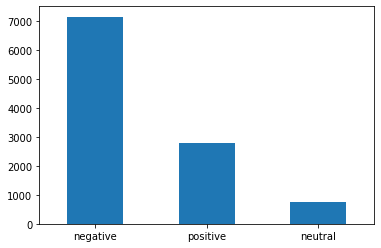

In [9]:
data.tone.value_counts().plot(kind="bar", rot = 0)

In [10]:
data.tone.value_counts()

negative    7148
positive    2774
neutral      746
Name: tone, dtype: int64

In [0]:
def tokenize(text):
  regex_tokenizer = RegexpTokenizer('[А-Яа-я]+')
  words = regex_tokenizer.tokenize(text.lower())
  stop_words = set(stopwords.words("russian"))
  without_stop_words = [w for w in words if w not in stop_words and len(w) > 1]
  return without_stop_words

In [0]:
sentences = np.array(data.term.apply(lambda x : tokenize(x)))

In [150]:
sentences[:10]

array([list(['остепеняться']), list(['трудолюбивый']),
       list(['беспалевный']), list(['порядочный']),
       list(['ответственнейший']), list(['солидность']),
       list(['самостоятельность']), list(['немаловажность']),
       list(['прогрессировать']), list(['легонький'])], dtype=object)

In [0]:
VECTOR_SIZE = 200
WINDOW_SIZE = 10
MIN_COUNT = 3
ITER_COUNT = 10
WORKERS = 4

In [0]:
# Обучение модели Word2Vec
word2vec_model = Word2Vec(sentences, min_count=1)

In [147]:
word2vec_model.most_similar('сочувствие')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('надебоширить', 0.3837495446205139),
 ('размеренный', 0.35682412981987),
 ('отбомбиться', 0.33674871921539307),
 ('освободительница', 0.3266671299934387),
 ('рисовка', 0.324972540140152),
 ('вор', 0.32436603307724),
 ('безучастность', 0.32359713315963745),
 ('интеллигентный', 0.31809690594673157),
 ('зрелищность', 0.31505706906318665),
 ('неудачник', 0.3129994869232178)]

In [0]:
# Преобразование названий классов в матрицу двоичных чисел (нужно для keras)
def transform_to_categorical(tones_for_each, unique_tones, build_binary_matrix = True):
  tones_to_digit = []

  for tone in tones_for_each:
    tones_to_digit.append(unique_tones.index(tone))

  if build_binary_matrix:
    tones_to_digit = to_categorical(tones_to_digit, len(unique_tones))
  
  return tones_to_digit

In [0]:
# Преобразование номеров классов в названия классов
def transform_from_categorical(prediction, unique_tones):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(unique_tones[prediction[i]])

  return answers

In [0]:
def get_model(word2vec_model, COUNT_CLASSES):
    model = Sequential() 
    model.add(word2vec_model.wv.get_keras_embedding(train_embeddings = True))
    
    model.add(Dropout(0.2))

    model.add(Conv1D(50,
                 3,
                 padding = 'valid',
                 activation = 'relu',
                 strides = 1))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(250))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    model.add(Dense(COUNT_CLASSES, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  
    return model

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Преобразование всех текстов в числовые последовательности, заменяя слова на числа по словарю.
text = tokenizer.texts_to_sequences(sentences)
text = pad_sequences(text, maxlen = 11)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(text, data.tone, test_size = 0.2)

In [0]:
y_train = transform_to_categorical(y_train, unique_tones.tolist())

In [0]:
COUNT_CLASSES = unique_tones.shape[0]

In [51]:
keras_model = get_model(word2vec_model, COUNT_CLASSES)
keras_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1074700   
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 50)          15050     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               12750     
_________________________________________________________________
dropout_8 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 250)              

In [0]:
BATCH = 32
EPOCHS_COUNT = 10

In [52]:
keras_model.fit(X_train, y_train, batch_size = BATCH, epochs = EPOCHS_COUNT, validation_split = 0.2)

Train on 6827 samples, validate on 1707 samples
Epoch 1/10
6827/6827 [==============================] - 5s 696us/step - loss: 0.8334 - acc: 0.6646 - val_loss: 0.7777 - val_acc: 0.6819
Epoch 2/10
6827/6827 [==============================] - 4s 600us/step - loss: 0.7096 - acc: 0.6930 - val_loss: 0.8066 - val_acc: 0.6825
Epoch 3/10
6827/6827 [==============================] - 4s 601us/step - loss: 0.1926 - acc: 0.9184 - val_loss: 1.1043 - val_acc: 0.2607
Epoch 4/10
6827/6827 [==============================] - 4s 592us/step - loss: 0.0236 - acc: 0.9959 - val_loss: 3.8325 - val_acc: 0.2613
Epoch 5/10
6827/6827 [==============================] - 4s 598us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 2.1686 - val_acc: 0.2613
Epoch 6/10
6827/6827 [==============================] - 4s 600us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 3.1099 - val_acc: 0.2613
Epoch 7/10
6827/6827 [==============================] - 4s 592us/step - loss: 0.0028 - acc: 0.9994 - val_loss: 3.1963 - val_acc: 0.2613


In [0]:
test = ['супер', 'классно', 'безупречный', 'убожество', 'убивать', 'нормально', 'ужас', 'отстой', 'шедевр'] 

In [0]:
#test_texts = np.array(test.apply(lambda x : tokenize(x)))
sequences_test = tokenizer.texts_to_sequences(test)
X_predict = pad_sequences(sequences_test, maxlen = X_train.shape[1])

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [157]:
answers = transform_from_categorical(prediction, unique_tones.tolist()) 
answers

['positive',
 'neutral',
 'positive',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'positive']

In [0]:
keras_model.save('drive/My Drive/keras_sentiment_new.h5')

# Попробуем классифицировать с помощью keras наш словарь

In [0]:
# загружаем глаголы из json файла
with open('drive/My Drive/verb.json', 'r', encoding='utf-8') as f:
    verbs = json.load(f)

In [164]:
words = []
for verb in verbs:
  words.append(verb[0])

from itertools import islice
list(islice(words, 150, 160))

['становиться',
 'помогать',
 'жрать',
 'подключить',
 'пытаться',
 'бояться',
 'помочь',
 'смотреться',
 'удалить',
 'разъесть']

In [0]:
sequences_words = tokenizer.texts_to_sequences(words)
X_predict = pad_sequences(sequences_words, maxlen = X_train.shape[1])

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [165]:
answers = transform_from_categorical(prediction, unique_tones.tolist()) 
list(islice(answers, 150, 160))

['neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral']

In [0]:
# создадим словарь
new_dictionary = { "verbs":[]}

for i in range(0, len(answers)):
  verbs_dict = {}
  verbs_dict[words[i]] = answers[i]
  new_dictionary["verbs"].append(verbs_dict)


In [175]:
list(islice(new_dictionary["verbs"], 150, 160))

[{'становиться': 'neutral'},
 {'помогать': 'positive'},
 {'жрать': 'neutral'},
 {'подключить': 'neutral'},
 {'пытаться': 'neutral'},
 {'бояться': 'negative'},
 {'помочь': 'positive'},
 {'смотреться': 'neutral'},
 {'удалить': 'neutral'},
 {'разъесть': 'neutral'}]

In [0]:
with open('drive/My Drive/dict_verbs.json', 'w', encoding='utf-8') as f:
    json.dump(new_dictionary, f, ensure_ascii=False, indent=4)

# Применим Word2Vec модель для создания словаря из полученных отзывов

In [0]:
import json

In [0]:
# загружаем исходные отзывы из json файла
with open('drive/My Drive/review_db.json', 'r', encoding='utf-8') as f:
    reviews = json.load(f)


In [81]:
reviews[:1]

['Телефон классный. Перечисляю достоинства.\n- Не глючит, довольно шустрый\n- Офигенный дизайн (мой - черный с оранжевым - супер! серый с черным фигня =) )\n- Стандартный браузер хороший, не особо привередливые пользователи могут даже не ставить оперу =)\n- Естессна сеть 3G и WiFi\n- Аккумулятор хороший, долго держит. Я - человек, который постоянно серфит по инету и юзает приложения и у меня этот тел держит дней 6.\n- Игры и приложения идут абсолютно все (если конечно качать с нуждны разрешением экрана)\nИ еще много-много плюсов! Их мало. Можно пересчитать по пальцам.\n1) WiFi подключается к точке только на относительно близком расстоянии (но потом при удалении от точки держит в радиусе ее действия)\n2) Стандартный браузер не может загрузить ооооочень большие страницы и иногда, чтобы освободить память берет и удбирает виджеты. Но это не страшно\n3) Маркий экран, от которого спасает пленка или постоянное натирание Советую всем, кому нужен сенсорный телефон с хорошими функционалом и мощн

In [0]:
sentences_review = []
for review in reviews:
   sentences_review.append(tokenize(review))

In [0]:
# Обучение модели Word2Vec
word2vec_model_review = Word2Vec(sentences_review, min_count=1)

In [143]:
word2vec_model_review.most_similar('дизайн')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('размер', 0.9689140319824219),
 ('изящный', 0.9631415605545044),
 ('стильный', 0.9618616104125977),
 ('солидный', 0.961808443069458),
 ('достаточная', 0.9579108357429504),
 ('симпатичный', 0.9563395977020264),
 ('качественная', 0.956101655960083),
 ('легкий', 0.9552664756774902),
 ('первоклассника', 0.9550947546958923),
 ('эргономичный', 0.9536789655685425)]

In [108]:
word2vec_model_review.most_similar('недостаток')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('минус', 0.9697523713111877),
 ('существенный', 0.9671847224235535),
 ('главный', 0.9629782438278198),
 ('единственный', 0.9351491928100586),
 ('запредельная', 0.9290320873260498),
 ('незначительный', 0.9287176728248596),
 ('невесомый', 0.9276562929153442),
 ('несомненный', 0.924570620059967),
 ('самый', 0.9151096940040588),
 ('это', 0.9135830402374268)]